# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, canonical, yes tail-exclusion train, yes tail-exclusion test, -1 threshold, learning module, cross-validation.

After seeing 100% learning fails during CV, try a smaller model here.

In [17]:
SEED = 44
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-04-29 19:38:01.071417


In [18]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP'
SAVE_DESCRIM_FILENAME = None # 'GMM'
LOAD_MODEL_FILENAME = None # 'MLP.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [19]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator # , ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = True
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = True
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [20]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [21]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [22]:
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
class ModelBuilder():
    def __init__(self,alphabet):
        self.alphabet = alphabet
        
    def build_model(self):
        mlp    = Sequential()
        layer1 = Dense(32, activation='sigmoid',dtype='float32',input_dim=self.alphabet)
        layer2 = Dense(16, activation='sigmoid')
        drop2  = Dropout(.2)
        layer3 = Dense(16, activation='sigmoid')
        drop3  = Dropout(.2)
        output = Dense(1, activation='sigmoid')
        mlp.add(layer1)
        mlp.add(layer2)
        mlp.add(drop2)
        mlp.add(layer3)
        mlp.add(drop3)
        mlp.add(output)
        bc=BinaryCrossentropy(from_logits=False)
        mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
        return mlp



In [23]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-04-29 19:38:03.118001
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4372 sequences.

Training # 1 1
2023-04-29 19:38:11.861742
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 748:674 52.60%
Computed class weights: {0: 1.0548961424332344, 1: 0.9505347593582888}
Valid 1:0 174:169 50.73%
FIT


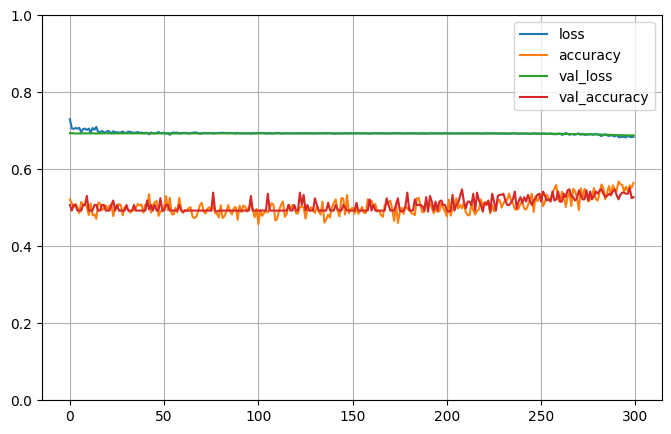


Testing # 1 1
2023-04-29 19:39:05.491953
PREDICT
Test 1:0 174:169 50.73%
Predict 1:0 114:229 33.24%
Test sizes (343, 1025) (343,)
Distrib of scores: 0.48635837 mean 0.03438756 std
Range of scores: 0.40059254 to 0.5856555
Score threshold 0.5
Confusion matrix
 [[118  51]
 [111  63]]
Normalized matrix
 [[0.34402332 0.14868805]
 [0.32361516 0.18367347]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


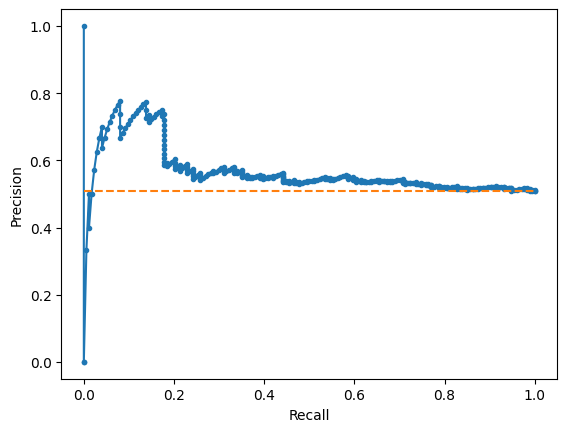

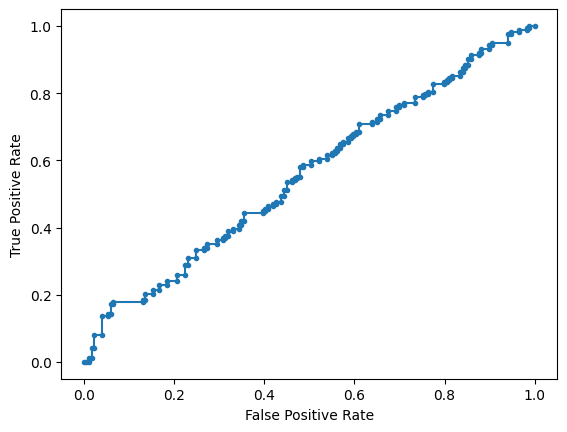

Accuracy: 52.77% Precision: 55.26% Recall: 36.21%
F1: 43.75% MCC: 0.0640
AUPRC: 56.47% AUROC: 55.65%
 accuracy [52.76967930029155]
 precision [55.26315789473685]
 recall [36.206896551724135]
 F1 [43.75]
 MCC [0.06399124979205177]
 AUPRC [56.46979075228897]
 AUROC [55.6451064408624]

Training # 1 2
2023-04-29 19:39:06.041074
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 741:692 51.71%
Computed class weights: {0: 1.0354046242774566, 1: 0.9669365721997301}
Valid 1:0 181:151 54.52%
FIT


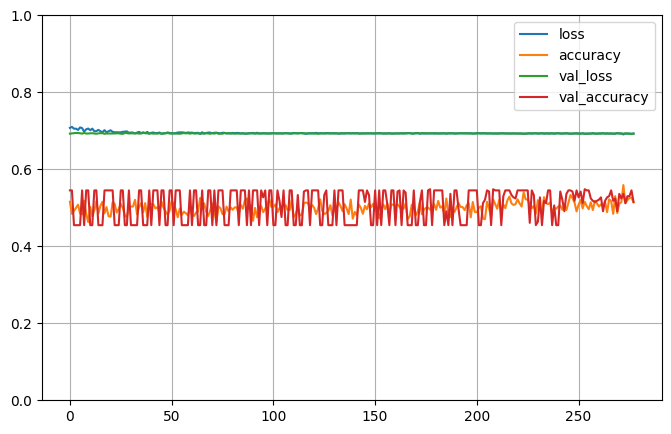


Testing # 1 2
2023-04-29 19:39:51.522456
PREDICT
Test 1:0 181:151 54.52%
Predict 1:0 329:3 99.10%
Test sizes (332, 1025) (332,)
Distrib of scores: 0.50035524 mean 0.00016997567 std
Range of scores: 0.49994683 to 0.5009089
Score threshold 0.5
Confusion matrix
 [[  2 149]
 [  1 180]]
Normalized matrix
 [[0.0060241  0.44879518]
 [0.00301205 0.54216867]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


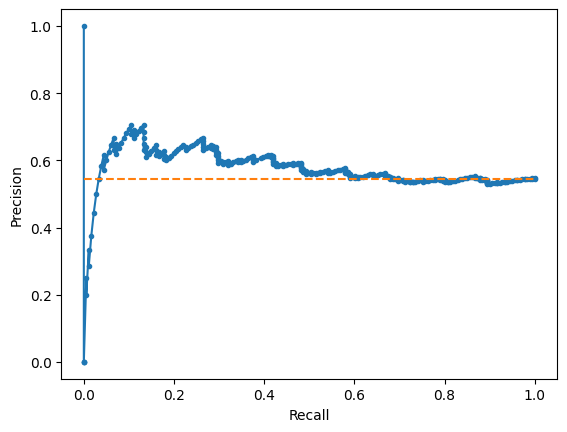

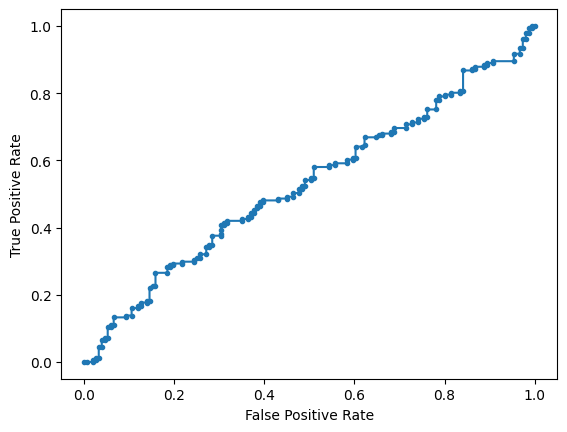

Accuracy: 54.82% Precision: 54.71% Recall: 99.45%
F1: 70.59% MCC: 0.0406
AUPRC: 57.50% AUROC: 52.92%
 accuracy [54.81927710843374]
 precision [54.7112462006079]
 recall [99.4475138121547]
 F1 [70.58823529411762]
 MCC [0.04062525667164027]
 AUPRC [57.500144578550085]
 AUROC [52.916102594123885]

Training # 1 3
2023-04-29 19:39:52.098580
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 740:658 52.93%
Computed class weights: {0: 1.0623100303951367, 1: 0.9445945945945946}
Valid 1:0 182:185 49.59%
FIT


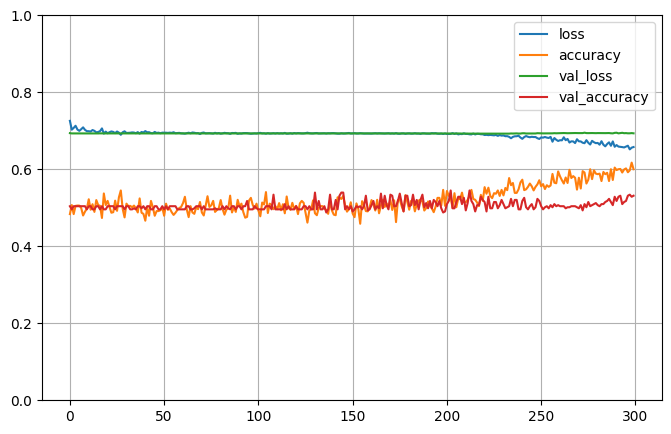


Testing # 1 3
2023-04-29 19:41:15.512169
PREDICT
Test 1:0 182:185 49.59%
Predict 1:0 148:219 40.33%
Test sizes (367, 1025) (367,)
Distrib of scores: 0.49814293 mean 0.08748827 std
Range of scores: 0.30893028 to 0.78292644
Score threshold 0.5
Confusion matrix
 [[116  69]
 [103  79]]
Normalized matrix
 [[0.31607629 0.1880109 ]
 [0.28065395 0.21525886]]
Extreme scores correct, pos:neg 18 3
Extreme scores incorrect pos:neg 11 1


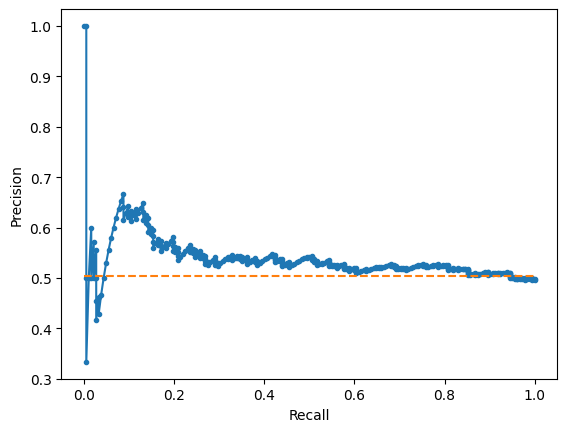

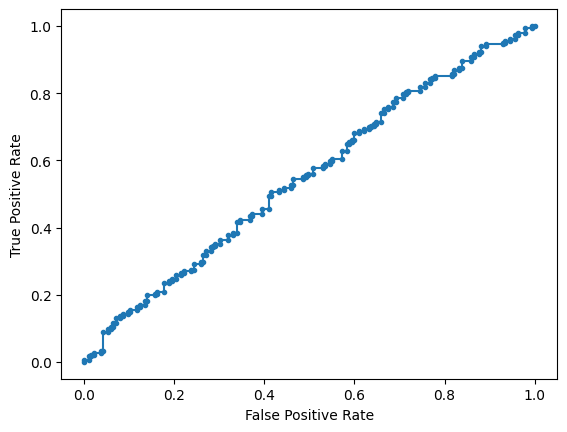

Accuracy: 53.13% Precision: 53.38% Recall: 43.41%
F1: 47.88% MCC: 0.0623
AUPRC: 53.75% AUROC: 55.02%
 accuracy [53.13351498637602]
 precision [53.37837837837838]
 recall [43.40659340659341]
 F1 [47.878787878787875]
 MCC [0.06226726901493441]
 AUPRC [53.7458088584311]
 AUROC [55.02227502227501]

Training # 1 4
2023-04-29 19:41:16.160970
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 714:679 51.26%
Computed class weights: {0: 1.0257731958762886, 1: 0.9754901960784313}
Valid 1:0 208:164 55.91%
FIT


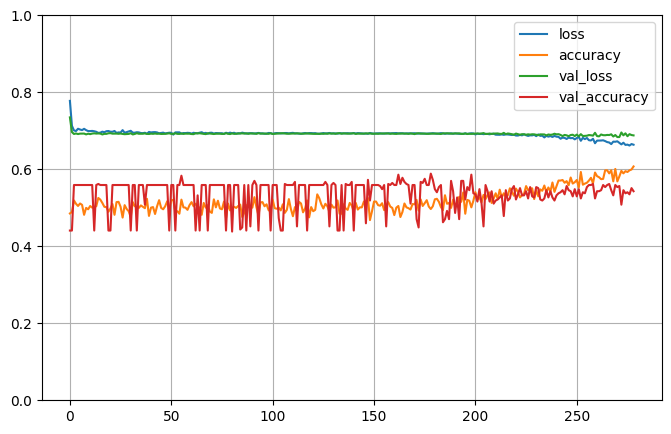


Testing # 1 4
2023-04-29 19:42:04.733168
PREDICT
Test 1:0 208:164 55.91%
Predict 1:0 297:75 79.84%
Test sizes (372, 1025) (372,)
Distrib of scores: 0.50100935 mean 0.0011877364 std
Range of scores: 0.497959 to 0.5049607
Score threshold 0.5
Confusion matrix
 [[ 43 121]
 [ 32 176]]
Normalized matrix
 [[0.1155914  0.32526882]
 [0.08602151 0.47311828]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


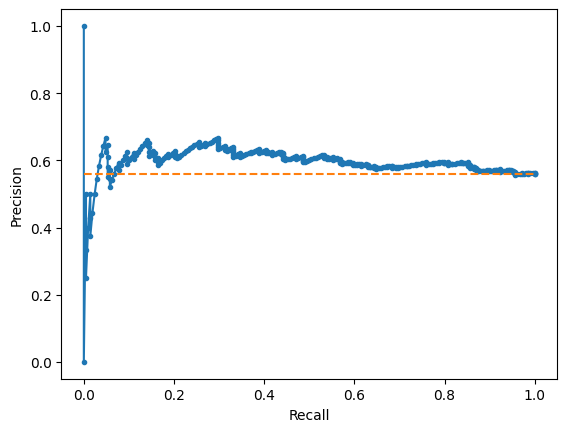

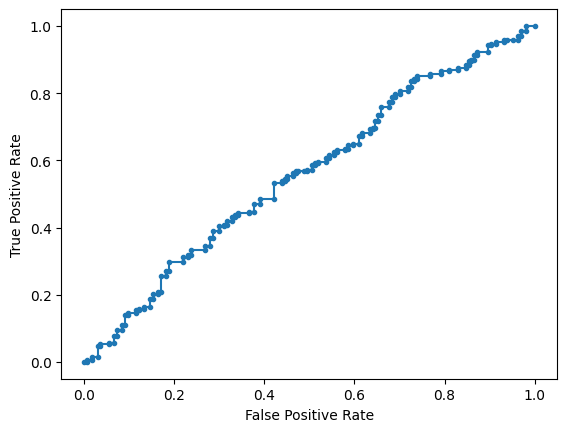

Accuracy: 58.87% Precision: 59.26% Recall: 84.62%
F1: 69.70% MCC: 0.1341
AUPRC: 59.55% AUROC: 56.10%
 accuracy [58.87096774193549]
 precision [59.25925925925925]
 recall [84.61538461538461]
 F1 [69.7029702970297]
 MCC [0.1340817021668193]
 AUPRC [59.54604702082364]
 AUROC [56.10342401500938]

Training # 1 5
2023-04-29 19:42:05.526916
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 745:669 52.69%
Computed class weights: {0: 1.0568011958146488, 1: 0.9489932885906041}
Valid 1:0 177:174 50.43%
FIT


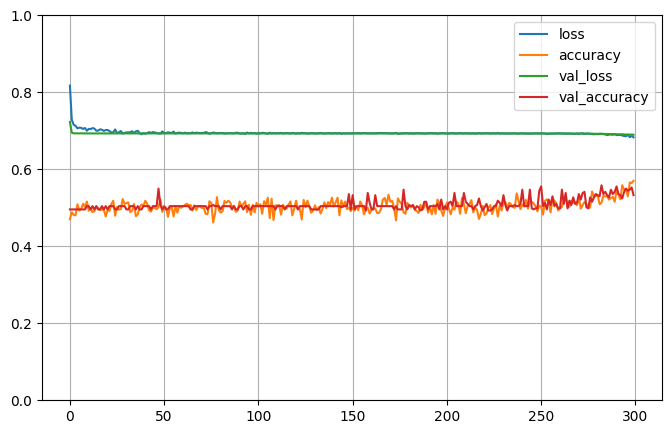


Testing # 1 5
2023-04-29 19:43:29.574994
PREDICT
Test 1:0 177:174 50.43%
Predict 1:0 153:198 43.59%
Test sizes (351, 1025) (351,)
Distrib of scores: 0.49898466 mean 0.025881313 std
Range of scores: 0.44508857 to 0.6057209
Score threshold 0.5
Confusion matrix
 [[104  70]
 [ 94  83]]
Normalized matrix
 [[0.2962963  0.1994302 ]
 [0.26780627 0.23646724]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


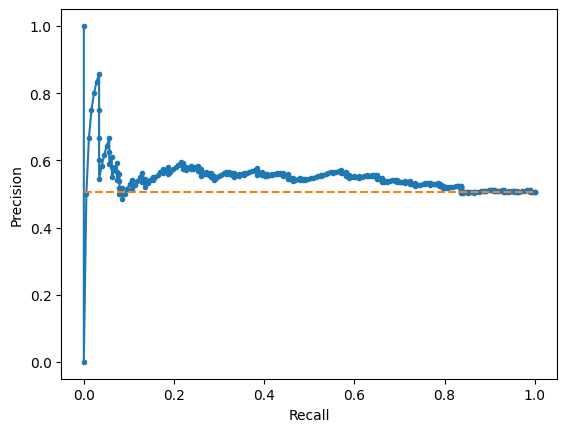

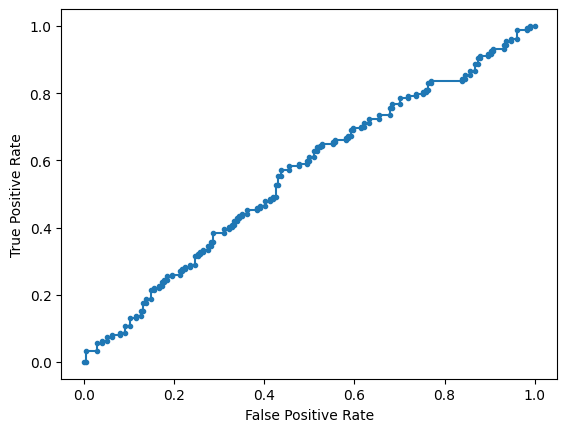

Accuracy: 53.28% Precision: 54.25% Recall: 46.89%
F1: 50.30% MCC: 0.0672
AUPRC: 54.85% AUROC: 55.63%
 accuracy [53.27635327635327]
 precision [54.248366013071895]
 recall [46.89265536723164]
 F1 [50.3030303030303]
 MCC [0.06717965799763378]
 AUPRC [54.854383029946916]
 AUROC [55.630235729592826]

Training # 2 1
2023-04-29 19:43:30.177620
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 747:660 53.09%
Computed class weights: {0: 1.065909090909091, 1: 0.9417670682730924}
Valid 1:0 175:183 48.88%
FIT


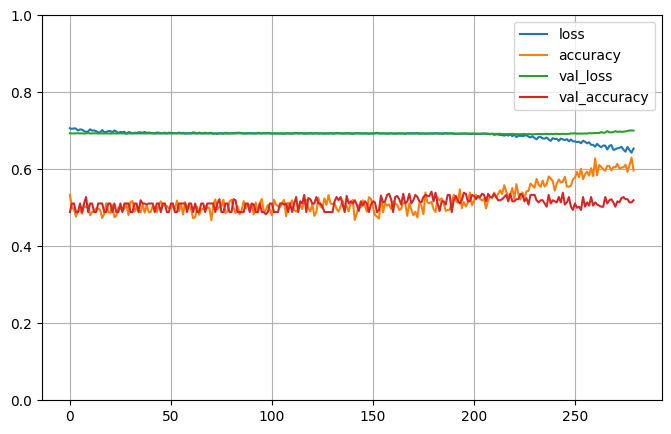


Testing # 2 1
2023-04-29 19:44:53.597673
PREDICT
Test 1:0 175:183 48.88%
Predict 1:0 149:209 41.62%
Test sizes (358, 1025) (358,)
Distrib of scores: 0.49980712 mean 0.001879179 std
Range of scores: 0.495705 to 0.50692344
Score threshold 0.5
Confusion matrix
 [[114  69]
 [ 95  80]]
Normalized matrix
 [[0.31843575 0.19273743]
 [0.26536313 0.22346369]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


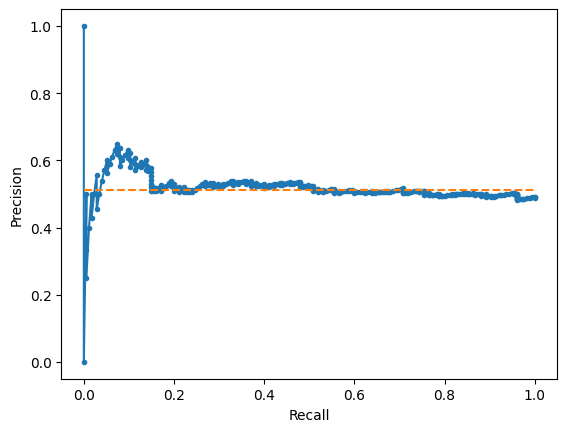

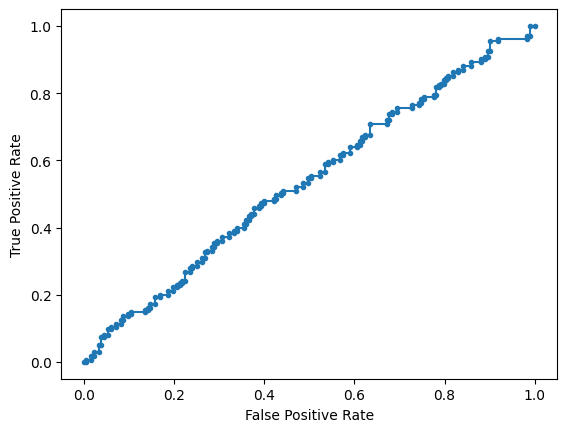

Accuracy: 54.19% Precision: 53.69% Recall: 45.71%
F1: 49.38% MCC: 0.0812
AUPRC: 51.76% AUROC: 53.71%
 accuracy [54.18994413407822]
 precision [53.691275167785236]
 recall [45.714285714285715]
 F1 [49.382716049382715]
 MCC [0.0812225318285904]
 AUPRC [51.759552822269825]
 AUROC [53.714285714285715]

Training # 2 2
2023-04-29 19:44:54.155967
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 751:675 52.66%
Computed class weights: {0: 1.0562962962962963, 1: 0.9494007989347537}
Valid 1:0 171:168 50.44%
FIT


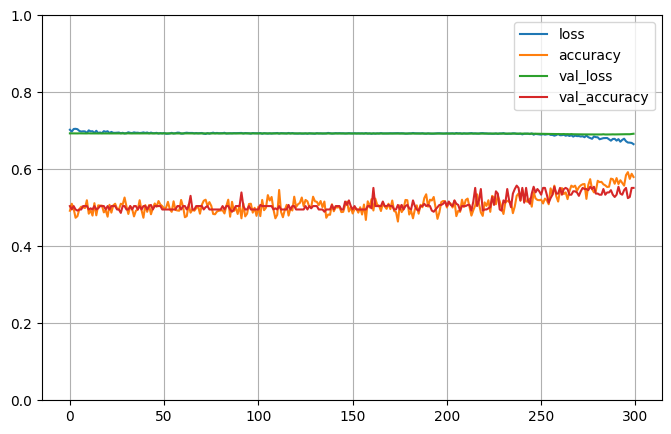


Testing # 2 2
2023-04-29 19:45:47.842233
PREDICT
Test 1:0 171:168 50.44%
Predict 1:0 225:114 66.37%
Test sizes (339, 1025) (339,)
Distrib of scores: 0.52588993 mean 0.060143482 std
Range of scores: 0.36723474 to 0.73102236
Score threshold 0.5
Confusion matrix
 [[ 65 103]
 [ 49 122]]
Normalized matrix
 [[0.19174041 0.30383481]
 [0.14454277 0.35988201]]
Extreme scores correct, pos:neg 6 0
Extreme scores incorrect pos:neg 8 0


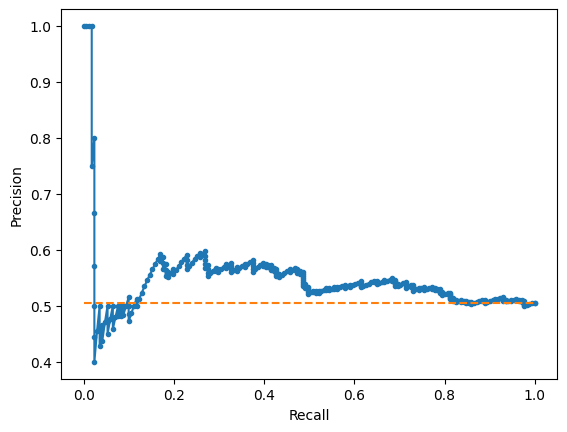

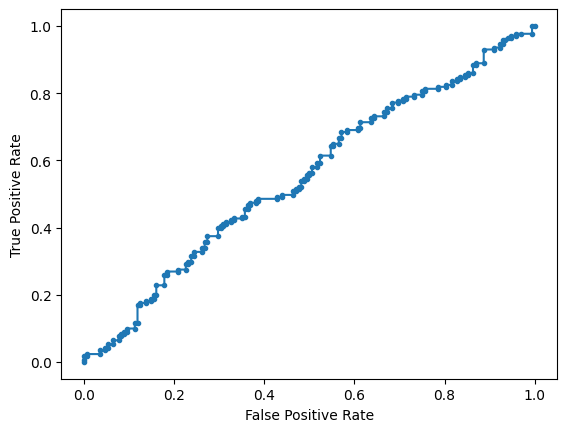

Accuracy: 55.16% Precision: 54.22% Recall: 71.35%
F1: 61.62% MCC: 0.1062
AUPRC: 54.56% AUROC: 55.08%
 accuracy [55.16224188790561]
 precision [54.22222222222223]
 recall [71.34502923976608]
 F1 [61.61616161616163]
 MCC [0.10620580659703724]
 AUPRC [54.56032201167429]
 AUROC [55.08040935672515]

Training # 2 3
2023-04-29 19:45:48.445989
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 721:686 51.24%
Computed class weights: {0: 1.0255102040816326, 1: 0.9757281553398058}
Valid 1:0 201:157 56.15%
FIT


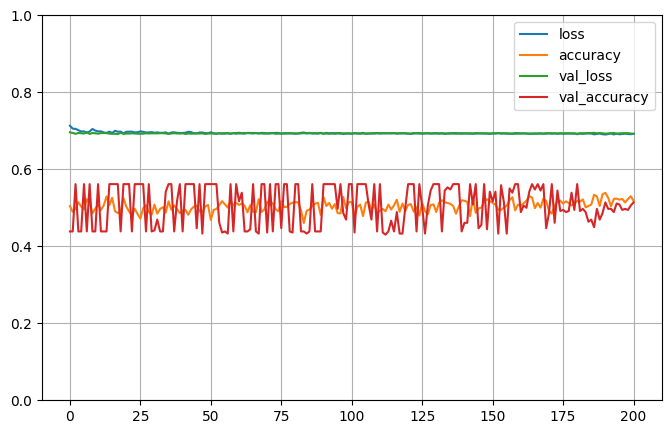


Testing # 2 3
2023-04-29 19:46:30.870123
PREDICT
Test 1:0 201:157 56.15%
Predict 1:0 358:0 100.00%
Test sizes (358, 1025) (358,)
Distrib of scores: 0.5009322 mean 0.00035183245 std
Range of scores: 0.5001677 to 0.50228816
Score threshold 0.5
Confusion matrix
 [[  0 157]
 [  0 201]]
Normalized matrix
 [[0.         0.43854749]
 [0.         0.56145251]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


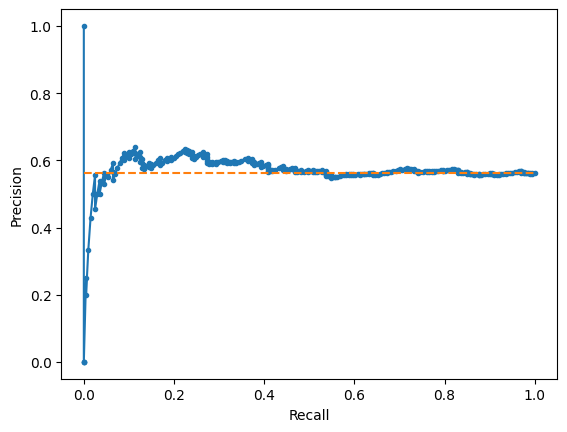

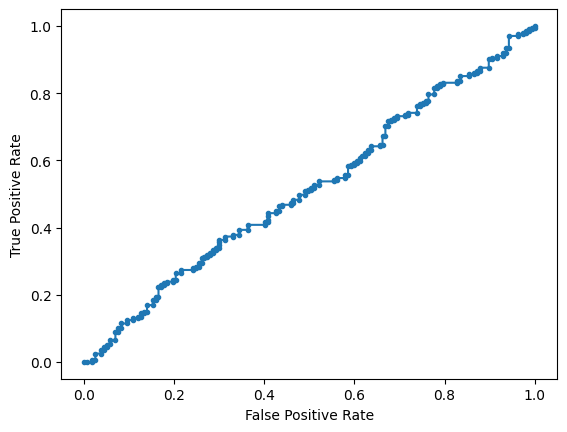

Accuracy: 56.15% Precision: 56.15% Recall: 100.00%
F1: 71.91% MCC: 0.0000
AUPRC: 57.06% AUROC: 51.58%
 accuracy [56.14525139664804]
 precision [56.14525139664804]
 recall [100.0]
 F1 [71.91413237924866]
 MCC [0.0]
 AUPRC [57.060220596528445]
 AUROC [51.57968121177552]

Training # 2 4
2023-04-29 19:46:31.525701
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 736:663 52.61%
Computed class weights: {0: 1.055052790346908, 1: 0.9504076086956522}
Valid 1:0 186:180 50.82%
FIT


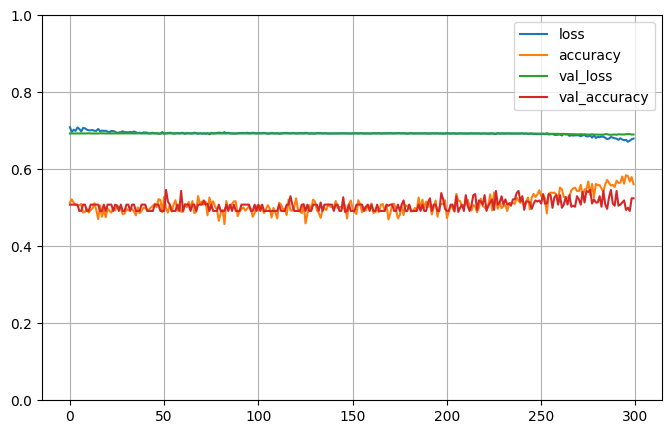


Testing # 2 4
2023-04-29 19:47:55.367177
PREDICT
Test 1:0 186:180 50.82%
Predict 1:0 220:146 60.11%
Test sizes (366, 1025) (366,)
Distrib of scores: 0.51625746 mean 0.05089715 std
Range of scores: 0.381355 to 0.68997544
Score threshold 0.5
Confusion matrix
 [[ 76 104]
 [ 70 116]]
Normalized matrix
 [[0.20765027 0.28415301]
 [0.19125683 0.31693989]]
Extreme scores correct, pos:neg 3 0
Extreme scores incorrect pos:neg 4 0


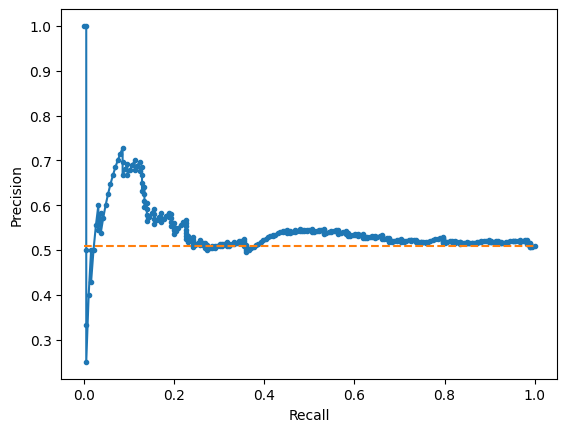

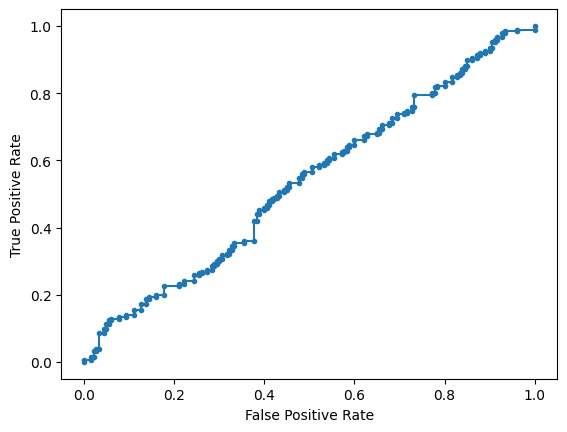

Accuracy: 52.46% Precision: 52.73% Recall: 62.37%
F1: 57.14% MCC: 0.0468
AUPRC: 54.26% AUROC: 53.50%
 accuracy [52.459016393442624]
 precision [52.72727272727272]
 recall [62.365591397849464]
 F1 [57.14285714285714]
 MCC [0.046839335234021416]
 AUPRC [54.25880686154878]
 AUROC [53.50059737156512]

Training # 2 5
2023-04-29 19:47:56.195738
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 733:688 51.58%
Computed class weights: {0: 1.032703488372093, 1: 0.9693042291950886}
Valid 1:0 189:155 54.94%
FIT


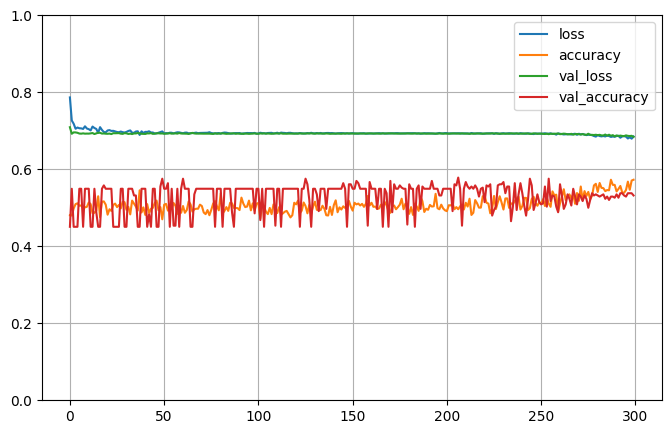


Testing # 2 5
2023-04-29 19:48:47.431569
PREDICT
Test 1:0 189:155 54.94%
Predict 1:0 234:110 68.02%
Test sizes (344, 1025) (344,)
Distrib of scores: 0.5190537 mean 0.04195715 std
Range of scores: 0.3866124 to 0.6176815
Score threshold 0.5
Confusion matrix
 [[ 52 103]
 [ 58 131]]
Normalized matrix
 [[0.15116279 0.2994186 ]
 [0.16860465 0.38081395]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


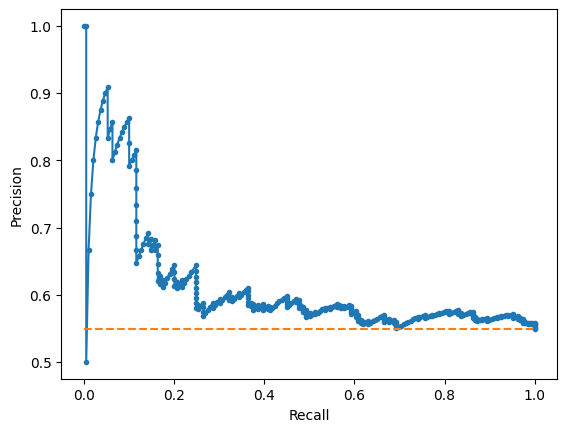

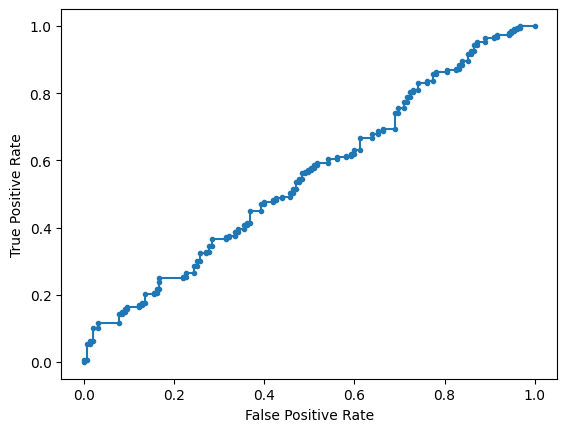

Accuracy: 53.20% Precision: 55.98% Recall: 69.31%
F1: 61.94% MCC: 0.0305
AUPRC: 61.29% AUROC: 55.20%
 accuracy [53.19767441860465]
 precision [55.98290598290598]
 recall [69.31216931216932]
 F1 [61.9385342789598]
 MCC [0.03051708140463521]
 AUPRC [61.291616460725216]
 AUROC [55.20395972008876]
2023-04-29 19:48:47.990876


In [24]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [25]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.40% std 1.96
 precision mean 54.96% std 1.86
 recall mean 65.93% std 23.21
 F1 mean 58.42% std 10.30
 MCC mean 0.0633 std 0.0381
 AUPRC mean 56.10% std 2.86
 AUROC mean 54.44% std 1.45
 accuracy [[52.76967930029155], [54.81927710843374], [53.13351498637602], [58.87096774193549], [53.27635327635327], [54.18994413407822], [55.16224188790561], [56.14525139664804], [52.459016393442624], [53.19767441860465]]
 precision [[55.26315789473685], [54.7112462006079], [53.37837837837838], [59.25925925925925], [54.248366013071895], [53.691275167785236], [54.22222222222223], [56.14525139664804], [52.72727272727272], [55.98290598290598]]
 recall [[36.206896551724135], [99.4475138121547], [43.40659340659341], [84.61538461538461], [46.89265536723164], [45.714285714285715], [71.34502923976608], [100.0], [62.365591397849464], [69.31216931216932]]
 F1 [[43.75], [70.58823529411762], [47.878787878787875], [69.7029702970297], [50.3030303030303], [49.382716049382715], [61.61616161616163], [71